## Supermarket sales forecasting 

- Build a model for forecasting total sales based on factors such as location, product type, promotions, etc. 
- Sample data: Supermarket Sales Dataset (Kaggle). 
- Analyze and prepare the data. 
- Use several (at least two) algorithms and compare their score with appropriate metrics and analyze the results.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 

# from sklearn.datasets import 


# Selection and loadning of the data set from Kaggle

The following dataset was selected [walmartcleaned](https://www.kaggle.com/datasets/ujjwalchowdhury/walmartcleaned/data), because:
 - it has features closely equivelent to the mentioned ones:  
   - location is not explicit, but there are 45 store;
   - product type is missing, but the Department plays a similar role;
   - promotions are present in the form of the 5 'MarkDown fileds' 
 - it has a significant amount of data   
 - it was a popular one 

421_570 rows × 17 columns


In [26]:
df_original = pd.read_csv('./Walmart/walmart.csv')
df_original.head()
df_original.tail()

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
421565,423281,45,2012-10-26,0,13.0,26240.14,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421566,423282,45,2012-10-26,0,16.0,2660.02,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421567,423283,45,2012-10-26,0,32.0,4131.54,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421568,423284,45,2012-10-26,0,83.0,717.82,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421569,423285,45,2012-10-26,0,98.0,1076.80,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221


First of all let's parse the Date to pandas native date format.
The Temperature could also be parsed to CElsium for convinience.
The Unnamed column which serves as an ID and is likely an index in an original uncleaned data set also seems not necessary so for faster manipulatiins a dataframe copy without it is also created:

In [38]:
df_original['Date'] = pd.to_datetime(df_original['Date'])
df = df_original.copy()
df['Temperature'] = (df['Temperature'] - 32) * 5.0/9.0
del df['Unnamed: 0']

df.tail()

,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
421565,45,2012-10-26,0,13.0,26240.14,14.916667,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421566,45,2012-10-26,0,16.0,2660.02,14.916667,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421567,45,2012-10-26,0,32.0,4131.54,14.916667,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421568,45,2012-10-26,0,83.0,717.82,14.916667,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421569,45,2012-10-26,0,98.0,1076.80,14.916667,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221


# Initial inspection of the data

First of all let's note the type of each feature, its range and if needed consult for its meaning.


,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
421565,423281,45,2012-10-26,0,13.0,26240.14,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421566,423282,45,2012-10-26,0,16.0,2660.02,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421567,423283,45,2012-10-26,0,32.0,4131.54,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421568,423284,45,2012-10-26,0,83.0,717.82,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421569,423285,45,2012-10-26,0,98.0,1076.80,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221


In [ ]:
df.describe()

,Unnamed: 0,Store,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,211611.321278,22.200546,0.070358,44.260317,15981.258123,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,2.410088,136727.915739
std,122195.149363,12.785297,0.255750,30.492054,22711.183519,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,0.666337,60980.583328
min,0.000000,1.000000,0.000000,1.000000,-4988.940000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,1.000000,34875.000000
25%,105782.250000,11.000000,0.000000,18.000000,2079.650000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,2.000000,93638.000000
50%,211603.500000,22.000000,0.000000,37.000000,7612.030000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,3.000000,140167.000000
75%,317424.750000,33.000000,0.000000,74.000000,20205.852500,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,3.000000,202505.000000
max,423285.000000,45.000000,1.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,3.000000,219622.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    421570 non-null  int64  
 1   Store         421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   IsHoliday     421570 non-null  int64  
 4   Dept          421570 non-null  float64
 5   Weekly_Sales  421570 non-null  float64
 6   Temperature   421570 non-null  float64
 7   Fuel_Price    421570 non-null  float64
 8   MarkDown1     421570 non-null  float64
 9   MarkDown2     421570 non-null  float64
 10  MarkDown3     421570 non-null  float64
 11  MarkDown4     421570 non-null  float64
 12  MarkDown5     421570 non-null  float64
 13  CPI           421570 non-null  float64
 14  Unemployment  421570 non-null  float64
 15  Type          421570 non-null  int64  
 16  Size          421570 non-null  int64  
dtypes: float64(11), int64(5), object(1)
memory usage

In [6]:
def describe_columns(df):
    summary = pd.DataFrame({
        "dtype": df.dtypes,
        "missing": df.isna().sum(),
        "unique": df.nunique(),
        "min": df.apply(lambda x: x.min() if np.issubdtype(x.dtype, np.number) else None),
        "max": df.apply(lambda x: x.max() if np.issubdtype(x.dtype, np.number) else None)
    })
    return summary

describe_columns(df)


,dtype,missing,unique,min,max
Unnamed: 0,int64,0,421570,0.000,423285.000000
Store,int64,0,45,1.000,45.000000
Date,object,0,143,NaN,NaN
IsHoliday,int64,0,2,0.000,1.000000
Dept,float64,0,81,1.000,99.000000
Weekly_Sales,float64,0,359464,-4988.940,693099.360000
Temperature,float64,0,3528,-2.060,100.140000
Fuel_Price,float64,0,892,2.472,4.468000
MarkDown1,float64,0,2278,0.000,88646.760000
MarkDown2,float64,0,1499,-265.760,104519.540000


As the data is alredy cleaned we see that there are no missing data at all. 

(Judging by the last index 423285 on row 421569, we can guess that 1716 entries have been cleaned)

1. Department and Store 

Dept
1.0     45
2.0     45
3.0     45
4.0     45
5.0     45
        ..
95.0    45
96.0    45
97.0    45
98.0    45
99.0    37
Name: Store, Length: 81, dtype: int64
Store
1     77
2     78
3     72
4     78
5     72
6     77
7     76
8     76
9     73
10    77
11    78
12    75
13    79
14    77
15    79
16    76
17    76
18    78
19    79
20    78
21    77
22    76
23    77
24    77
25    77
26    76
27    78
28    77
29    77
30    64
31    76
32    77
33    63
34    78
35    74
36    63
37    62
38    63
39    75
40    77
41    77
42    62
43    61
44    62
45    74
Name: Dept, dtype: int64


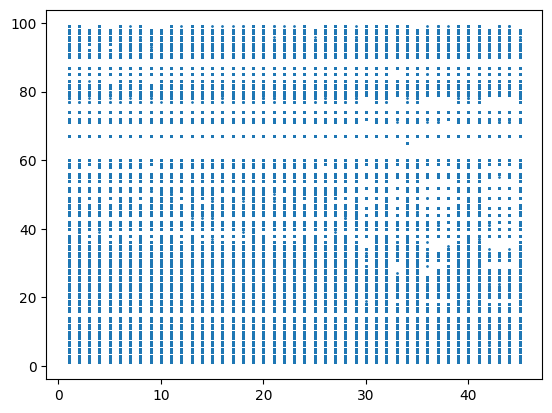

In [7]:
deperatment_freq_over_stores = df.groupby(by="Dept")["Store"].nunique()
print(deperatment_freq_over_stores)
number_of_departments_per_store = df.groupby(by="Store")["Dept"].nunique()
print(number_of_departments_per_store)

plt.scatter(df["Store"], df["Dept"], s=1) 

The distribution of the departments across stores is quite uniform.
An agregation of the departments in a store and grouping of the data from all stores for a given department are both meaningful.

Let's see the distribution of the sales across these 2 features, for a given date:

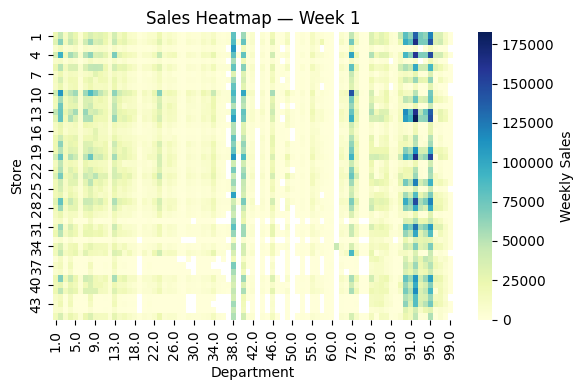

In [8]:
grouped = (df.groupby(['Store', 'Dept']))['Weekly_Sales'].mean().reset_index()
pivot = grouped.pivot(index='Store', columns='Dept', values='Weekly_Sales')

plt.figure(figsize=(6, 4))
sns.heatmap(pivot, annot=False, cmap="YlGnBu", cbar_kws={'label': 'Weekly Sales'})
plt.title(f"Sales Heatmap — Week 1")
plt.ylabel("Store")
plt.xlabel("Department")
plt.tight_layout()
plt.show()

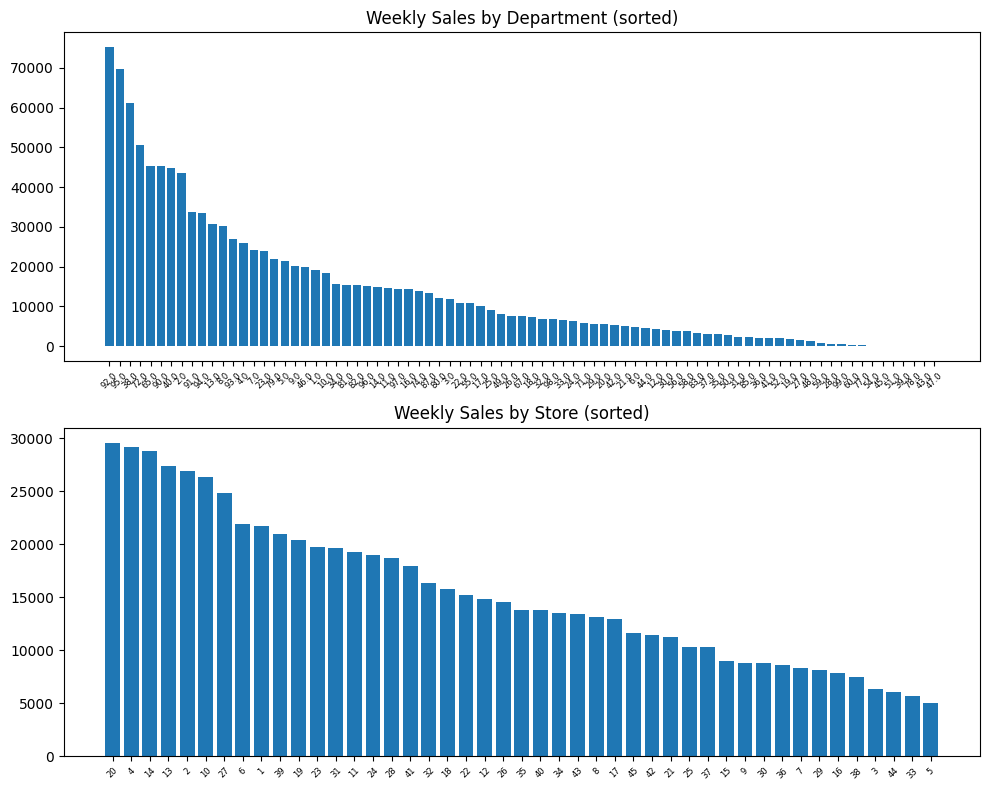

In [9]:
total_by_store = (df.groupby(['Store']))['Weekly_Sales'].mean().reset_index() # total sales per store summed over over all departments and dates
total_by_store_sorted = total_by_store.sort_values(by='Weekly_Sales', ascending=False)

total_by_dept = (df.groupby(['Dept']))['Weekly_Sales'].mean().reset_index() # total sales per department summed over over all stores and dates
total_by_dept_sorted = total_by_dept.sort_values(by='Weekly_Sales', ascending=False)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# by Dept
axes[0].bar(
    total_by_dept_sorted["Dept"].astype(str),
    total_by_dept_sorted["Weekly_Sales"]
)
axes[0].set_title("Weekly Sales by Department (sorted)")
axes[0].tick_params(axis="x", rotation=45, labelsize=6)

# by Store
axes[1].bar(
    total_by_store_sorted["Store"].astype(str),
    total_by_store_sorted["Weekly_Sales"]
)
axes[1].set_title("Weekly Sales by Store (sorted)")
axes[1].tick_params(axis="x", rotation=45, labelsize=6)

plt.tight_layout()
plt.show()


We see a higher variance over the departments than the stores.

CPI is Consumer price index ... measures the average change over time in prices paid by urban consumers for a market basket of goods and services
Lets see its trend over time 

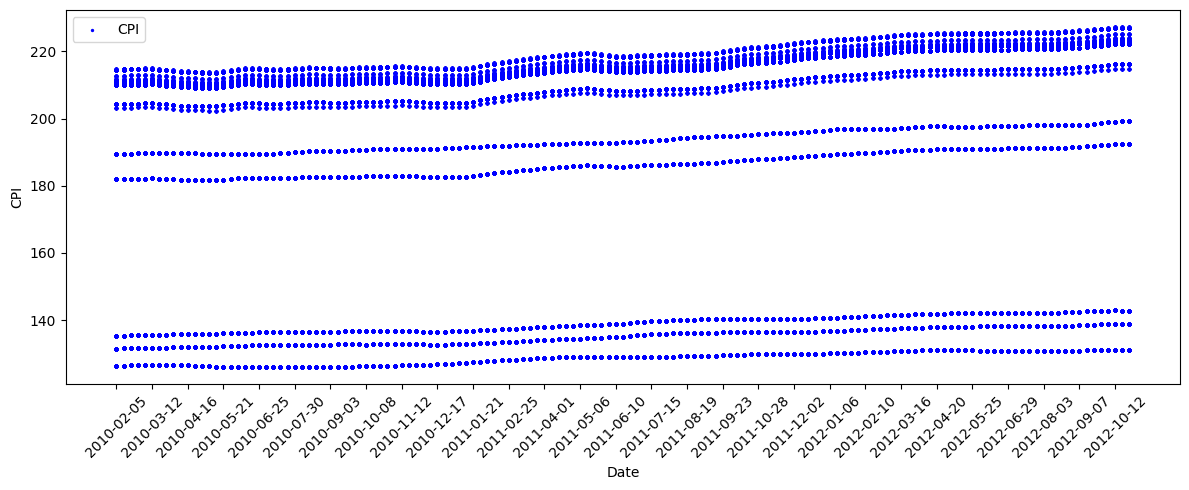

In [10]:
# df_store_1 = df[df['Store'] == 31]

ax = df.plot(x='Date', y='CPI', kind='scatter', figsize=(12, 5), s=2, color='blue', label='CPI')
plt.xticks(rotation=45)
ax.set_xticks(ax.get_xticks()[::5])
plt.tight_layout()


<Axes: xlabel='Date'>

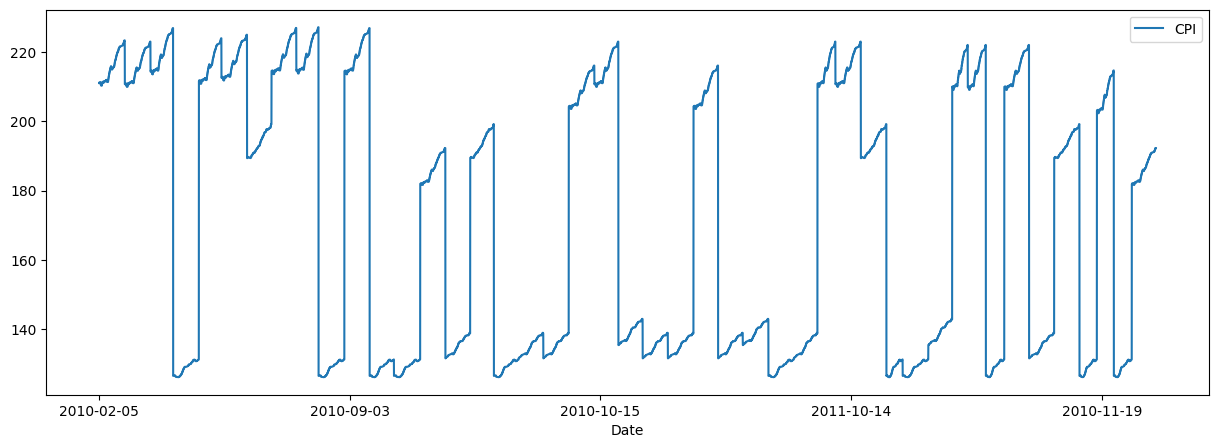

In [11]:
df.plot(x='Date', y='CPI', kind='line', figsize=(15, 5))

To check if Type and Size quantify the sales - lets observe some polots

A complete scatter matrix could be created (in ~10min). But let's focus more on the time dependence.
For that we extract the realtive week from each date.
Also as the Department 

In [40]:
def smart_aggregate(df, group_cols=['Store', 'Date'], sum_col='Weekly_Sales'):
    """
    Automatically handle columns based on their consistency
    """
    # Get all non-grouping columns except the sum column
    other_cols = [col for col in df.columns 
                  if col not in group_cols and col != sum_col]
    
    agg_dict = {sum_col: 'sum'}  # Always sum the sales
    
    for col in other_cols:
        # Check if column has consistent values within groups
        is_consistent = df.groupby(group_cols)[col].nunique().max() == 1
        
        if is_consistent:
            # Take first value (all are same)
            agg_dict[col] = 'first'
        else:
            print(f"Column '{col}' has conflicting values within groups.")
            # Choose appropriate aggregation based on dtype
            if pd.api.types.is_numeric_dtype(df[col]):
                agg_dict[col] = 'mean'  # Average for numeric
            else:
                # For categorical conflicts - just throw
                raise ValueError(f"Explicit categorical non numeric values in column '{col}'")
    
    return df.groupby(group_cols).agg(agg_dict).reset_index()

# grouped = smart_aggregate(df, ['Store', 'Date'], 'Weekly_Sales')
# print(grouped.head())

Column 'Dept' has conflicting values within groups.


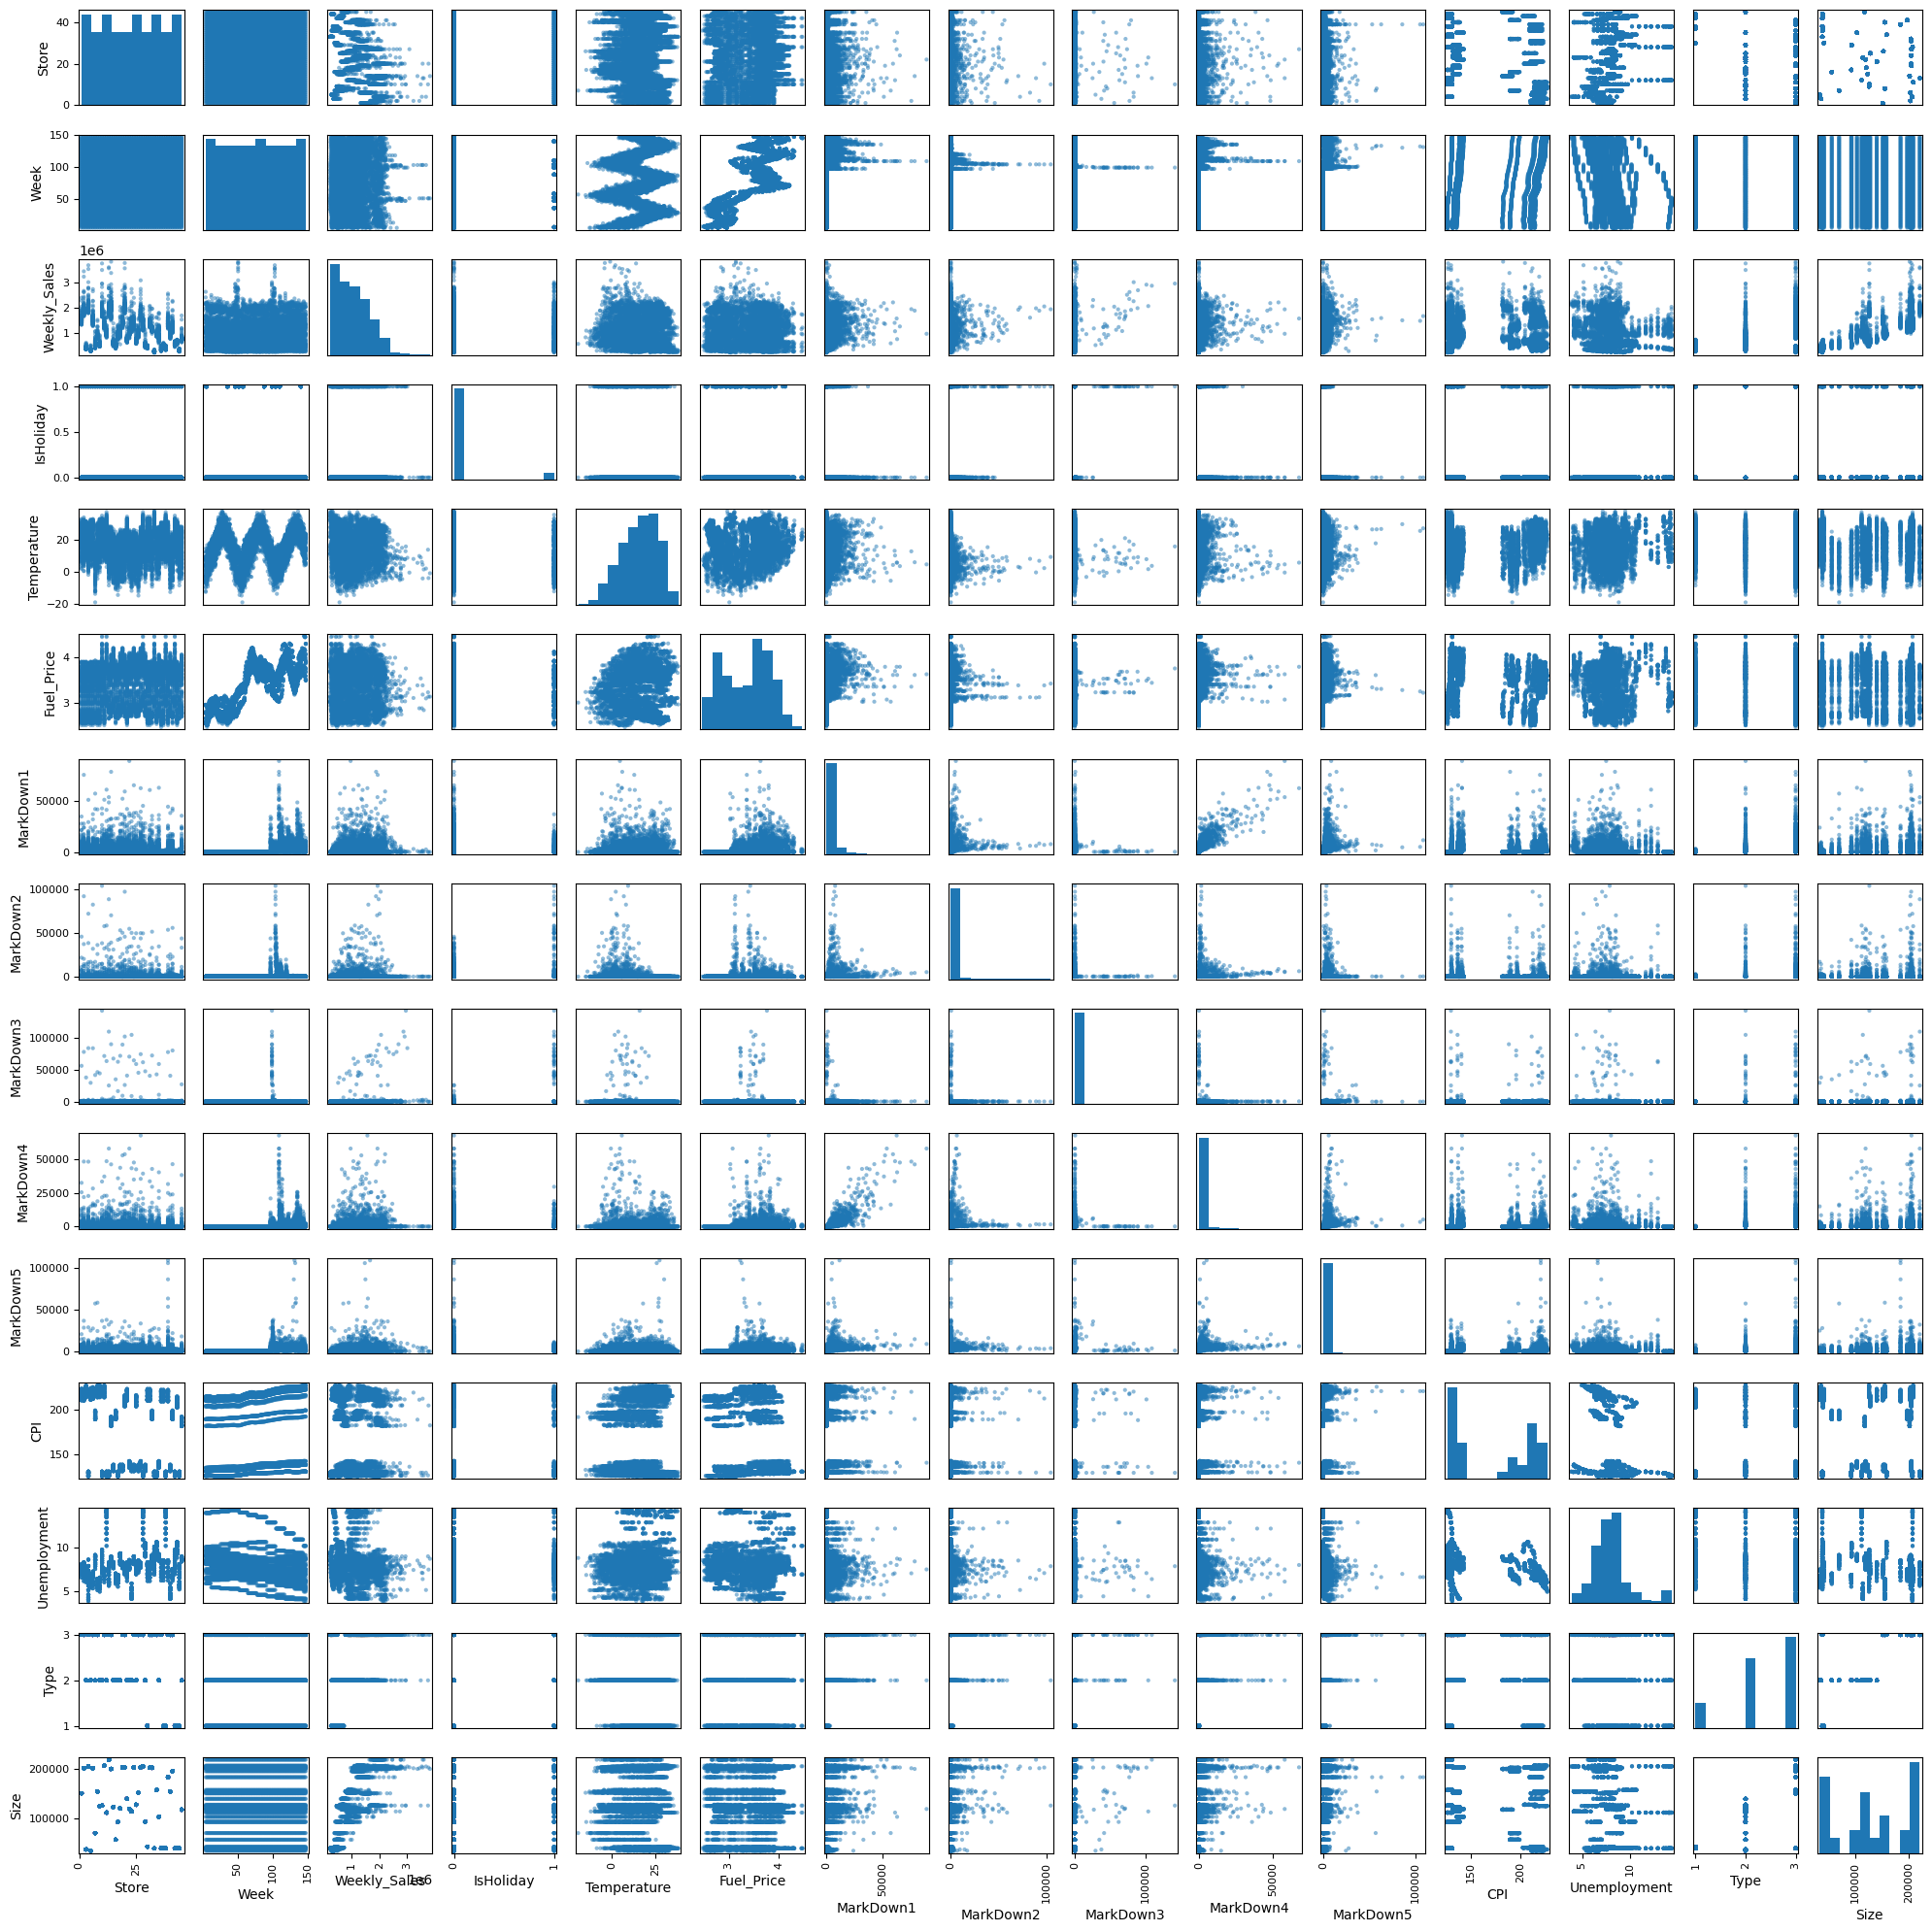

In [43]:
start_year = df['Date'].dt.year.min()
df_with_weeks = df.copy()
df_with_weeks['Week'] = df_with_weeks['Date'].dt.isocalendar().week + (df_with_weeks['Date'].dt.year - start_year) * 52
# df_with_weeks = (df_with_weeks.groupby(['Store']))['Weekly_Sales'].mean().reset_index()
df_with_weeks = smart_aggregate(df_with_weeks, ['Store', 'Week'], 'Weekly_Sales')
df_with_weeks.pop('Dept')
df_with_weeks.tail()

# df_with_weeks = df_with_weeks.iloc[: , [2, 3, 4, 5, 6, 7, 8]]  # keep only numeric columns for scatter matrix

pd.plotting.scatter_matrix(df_with_weeks.head(10000), figsize=(20, 20), diagonal='hist')
plt.tight_layout()
plt.show()

We see that some variables are quite correlated. For example MarkDown1 and Markdown4; and the Size and Type of the store.
Others we see are correlated on the time and often the same feature is dependend on the Store (i.e. the place). Examples for such features are: Temperature, Fuel_Price, CPI, Unemployment. 

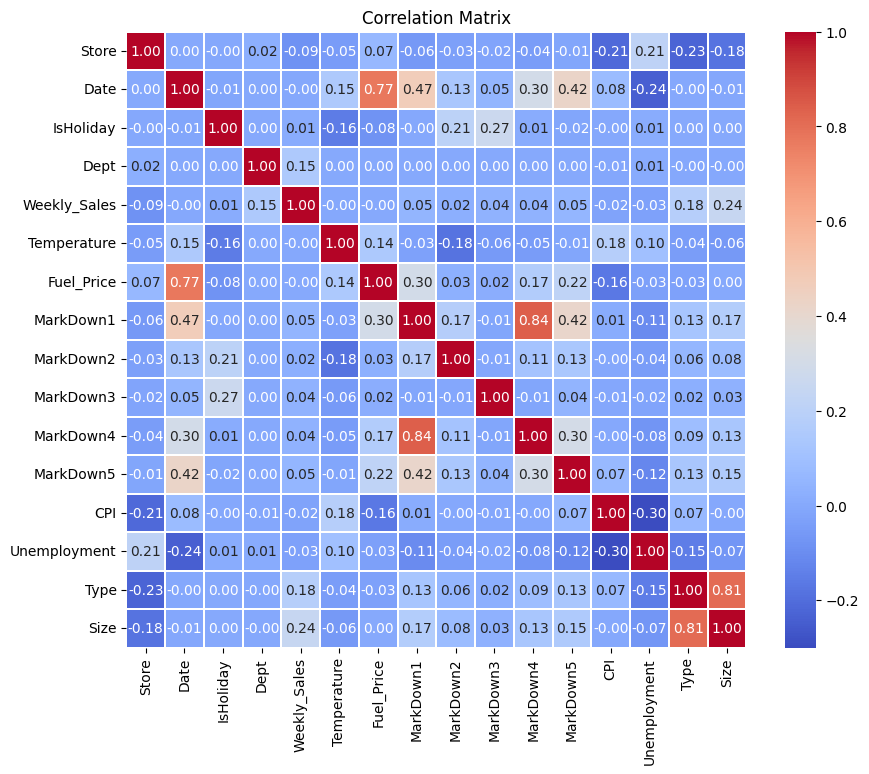

In [48]:
# Heatmap of the correlation matrix
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.05)
plt.title('Correlation Matrix')
plt.show()

To be easier to 